In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

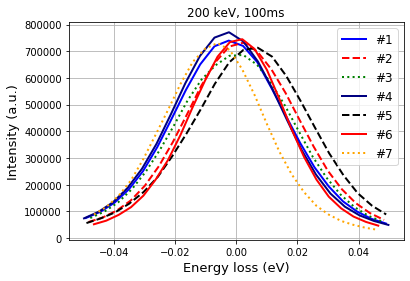

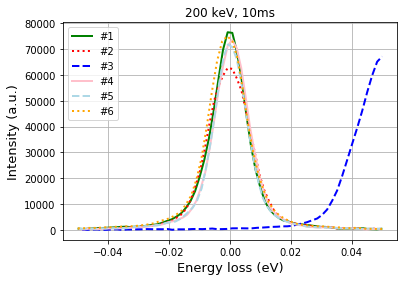


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 5


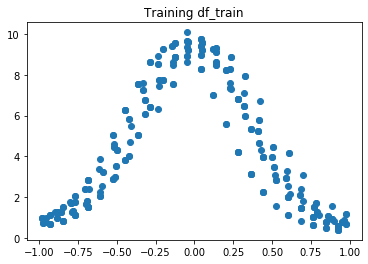

In [208]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py

seed = seednumber


### Find uncertainties on data

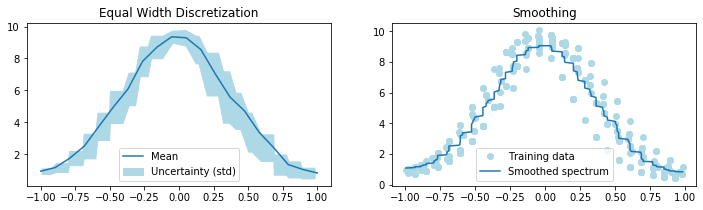

The total number of training datapoints is 320 and validation points is 138


In [334]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

nbins = 20
minval = -1
maxval = +1

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data(100)
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plt.subplot(1, 2, 1)
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.title('Equal Width Discretization')
fig.set_size_inches(12, 5)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]


### Apply smoothing to the signal
N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
smoothing_window_train = 100
smooth_y = np.array(smooth(df_train[:,1], 80))
smooth_y_test = np.array(smooth(df_val[:,1], 30))

plt.subplot(1,2,2)
plt.plot(df_train[:,0], df_train[:,1], 'o', color='lightblue', label='Training data')
plt.plot(df_train[:,0], smooth_y, label='Smoothed spectrum')
fig.set_size_inches(12,3)
plt.title('Smoothing')
plt.legend()
plt.show()

print("The total number of training datapoints is", N_train, "and validation points is", N_test)


## Neural Network 

### Create architecture

In [210]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_4 = tf.nn.dropout(hidden_layer_3, 0.1)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

# User defined Neural Network


### Prepare data for training

Shape of this round of Monte Carlo replicas is: (320, 1)
Example of one training x, shape (,2): [-0.51523389  1.        ]
Example of one training y, shape (,1): [5.73452968]
Start training on 0320 and validating on 0138 samples
Epoch: 0001 | Training cost= 64.917976379 | Validation cost= 127.531982422
Epoch: 5001 | Training cost= 40.954086304 | Validation cost= 78.010299683
Epoch: 10001 | Training cost= 36.950595856 | Validation cost= 70.080848694
Epoch: 15001 | Training cost= 13.541299820 | Validation cost= 24.995117188
Epoch: 20001 | Training cost= 2.060322046 | Validation cost= 2.269322395
Epoch: 25001 | Training cost= 1.772703171 | Validation cost= 2.041417360
Epoch: 30001 | Training cost= 1.770749331 | Validation cost= 2.066054106
Epoch: 35001 | Training cost= 1.769751191 | Validation cost= 2.081525326
Epoch: 40001 | Training cost= 1.769140959 | Validation cost= 2.089460611

 The session stopped because of overfitting...
Start overfitting at epoch: 41796 | Validation cost = 2.0913

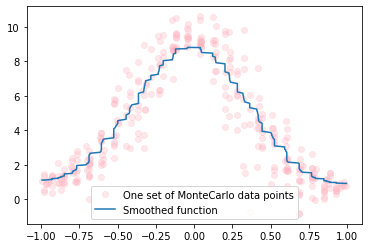

In [293]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])

train_x = add_time(df_train, 100)
train_y = copy(df_train[:,1]).reshape(N_train,1)  ## train_y = smooth_y in case of smoothing
train_sigma = df_train[:,2].reshape(N_train,1)
train_y +=  np.random.normal(0, train_sigma) # Create one replica of the training set
print("Shape of this round of Monte Carlo replicas is:", train_y.shape)

test_x = add_time(df_val, 100)
test_y = copy(df_val[:,1]).reshape(N_test,1)
test_sigma = df_val[:,2].reshape(N_test,1)
test_y +=  np.random.normal(0, test_sigma) # Create Monte Carlo points

predictions = make_model(x,1)

    ### Define cost and optimizer

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

plt.plot(train_x[:,0], train_y, 'o', alpha=.3, color='lightpink', label='One set of MonteCarlo data points')
plt.plot(train_x[:,0], smooth_y, label='Smoothed function')
plt.legend()
plt.show

print("Example of one training x, shape (,2):", train_x[80,:])
print("Example of one training y, shape (,1):", train_y[80])

# Scaling input features to help the minimizer.
train_scaler = StandardScaler()
train_scaler.fit(train_x[:,0].reshape(1,-1))
test_scaler = StandardScaler()
test_scaler.fit(test_x[:,0].reshape(1,-1))

### Train and validate

training_epochs = 50000
max_rising_epochs = 20000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 5000
prev_test_cost = 100
prev_epoch=0
avg_cost = 0.0

array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x,
                            y: train_y,
                            sigma: train_sigma
                        })
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The session stopped because of overfitting...","red"))
            print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
            break
        
            
        elif test_cost < prev_test_cost:
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x,
                            y: train_y 
                        })
sess.close()
    
# save to csv file
from datetime import datetime
predictions_values = predictions_values.reshape(N_train,)

#foot = np.array(seednumber)
a = np.array(train_x[:,0])
b = np.array(train_y)
c = np.array(predictions_values)
d = array_train
e = array_test

now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seed}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seed}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')



### Plot outputs

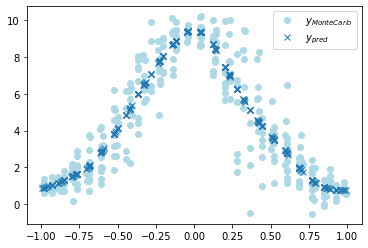

In [290]:
plt.plot(train_x[:,0], train_y, 'o', label='$y_{MonteCarlo}$', color='lightblue')
plt.plot(train_x[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
plt.show()

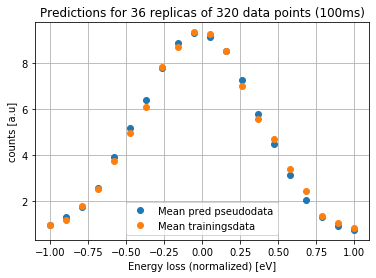

In [335]:
%run Evaluate_pseudodata.ipynb

#plt.plot(train_x, train_y,'o')
#plt.plot(pseudo_x, pseudo_pred, 'x', color='lightblue', label='Predictions')
plt.title('Predictions for 36 replicas of 320 data points (100ms)')

plt.plot(pseudo_meanvector, pseudo_mean, 'o', label = 'Mean pred pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 20), mean_t, 'o', label='Mean trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()

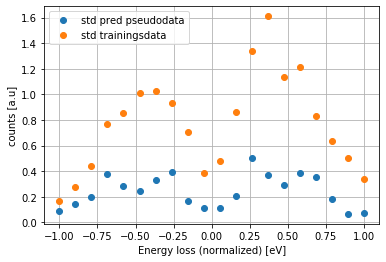

In [342]:
plt.plot(pseudo_meanvector, pseudo_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval, 20), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()
plt.show()